In [17]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [18]:
class ViscousBurgersEquation:
    def __init__(self, v, L, N, u_initial):
        self.v, self.L, self.N = v, L, N
        self.dx = L / (N - 1)
        self.x = np.linspace(-L/2, L/2, N)
        self.u_initial = u_initial(self.x)  # Initial condition (array of velocity at each grid point)

    # def model(self, u, t):
    #     dudt = np.zeros_like(u)
    #     # Central difference in space, forward difference in time!

    #     for i in range(1, self.N-1):
    #         dudx = (u[i] - u[i-1]) / self.dx
    #         dudx2 = (u[i+1] - 2*u[i] + u[i-1]) / self.dx**2
    #         dudt[i] = -u[i] * dudx + self.v * dudx2
    #     # Dirichlet boundary conditions
    #     dudt[0] = dudt[-1] = 0.0
    #     return dudt

    def model(self, u, t):
        # Using Upwind for better estimate
        dudt = np.zeros_like(u)
        dx = self.dx

        for i in range(1, self.N-1):

            # Upwind first-order for advection term
            if u[i] >= 0:
                dudx_upwind = (u[i] - u[i-1]) / dx
            else:
                dudx_upwind = (u[i+1] - u[i]) / dx

            # Central difference for diffusion term
            dudx2_central = (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)

            dudt[i] = -u[i] * dudx_upwind + self.v * dudx2_central

        # Apply boundary conditions
        dudt[0] = dudt[-1] = 0.0

        return dudt


    def solve(self, t):
        u = odeint(self.model, self.u_initial, t)
        return u

In [19]:
v = 1 / (100 * np.pi)
L = 2
Np_phys = 10**3
u_initial = lambda x: -np.sin(np.pi * x)

VB = ViscousBurgersEquation(v, L, Np_phys, u_initial)

In [20]:
t_phys = np.linspace(0, 1, Np_phys)

sol_phys = VB.solve(t_phys)

print(sol_phys)

[[ 1.22464680e-16  6.28943332e-03  1.25786178e-02 ... -1.25786178e-02
  -6.28943332e-03 -1.22464680e-16]
 [ 1.22464680e-16  6.26952050e-03  1.25387949e-02 ... -1.25387949e-02
  -6.26952050e-03 -1.22464680e-16]
 [ 1.22464680e-16  6.24973399e-03  1.24992254e-02 ... -1.24992254e-02
  -6.24973399e-03 -1.22464680e-16]
 ...
 [ 1.22464681e-16  1.51798323e-03  3.03596553e-03 ... -3.03596553e-03
  -1.51798323e-03 -1.22464680e-16]
 [ 1.22464681e-16  1.51683123e-03  3.03366153e-03 ... -3.03366153e-03
  -1.51683123e-03 -1.22464680e-16]
 [ 1.22464681e-16  1.51568097e-03  3.03136102e-03 ... -3.03136102e-03
  -1.51568097e-03 -1.22464680e-16]]


In [21]:
data_min = np.min(sol_phys)
data_min_arg = np.argmin(sol_phys)
data_max = np.max(sol_phys)
data_max_arg = np.argmax(sol_phys)
print(f"Data min: {data_min} at {data_min_arg}, Data max: {data_max} at {data_max_arg}")

Data min: -0.9999987638285974 at 749, Data max: 0.9999987638285974 at 250


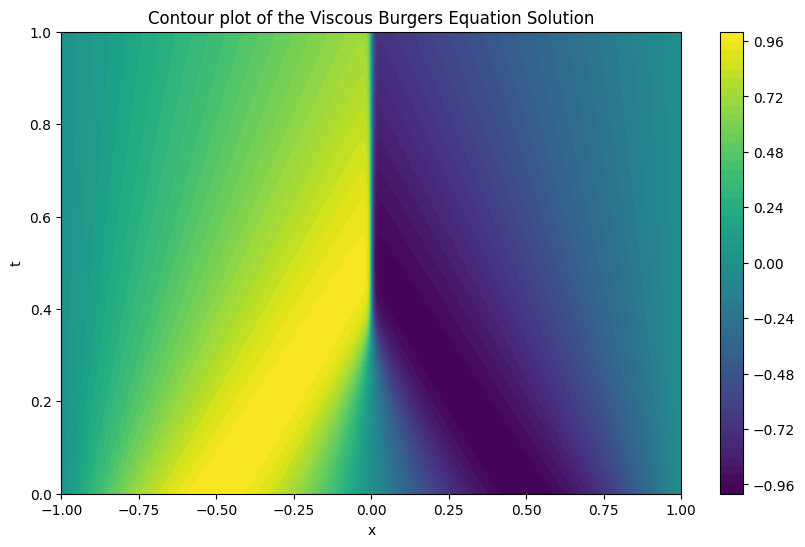

In [22]:
X, T = np.meshgrid(VB.x, t_phys)

if np.any(np.isinf(sol_phys)):
    raise Exception("Data contains Infs, which cannot be plotted.")

# Contour plot
plt.figure(figsize=(10, 6))
norm = Normalize(vmin=data_min, vmax=data_max)
contour = plt.contourf(X, T, sol_phys, 50, cmap='viridis', norm=norm)

plt.colorbar(contour)

plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour plot of the Viscous Burgers Equation Solution')

plt.show()